In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import time

seed = 42
# PyTorch
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)       # 为当前GPU设置
    torch.cuda.manual_seed_all(seed)   # 为所有GPU设置
# Python
random.seed(seed)
# NumPy
np.random.seed(seed)

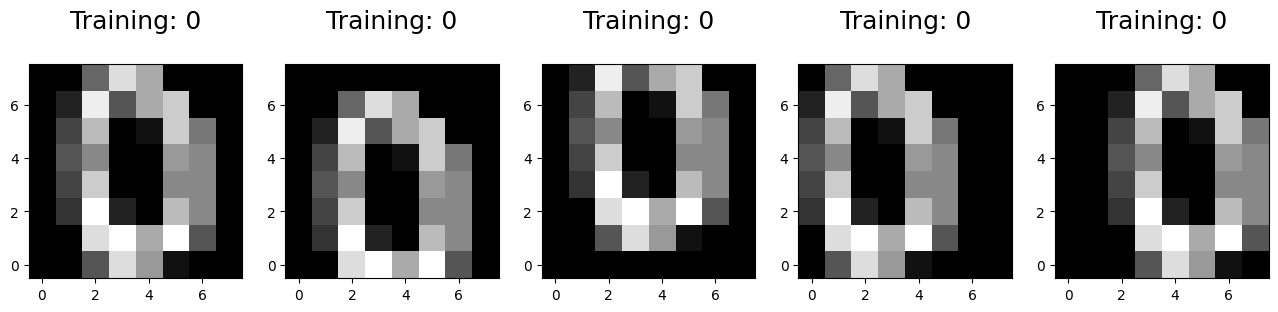

In [9]:
from scipy.ndimage import shift
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline

def translate_image(image, direction):
    "图片转换"
    if direction == "up":
        return shift(image, [-1, 0], mode="constant", cval=0)
    elif direction == "down":
        return shift(image, [1, 0], mode="constant", cval=0)
    elif direction == "left":
        return shift(image, [0, -1], mode="constant", cval=0)
    elif direction == "right":
        return shift(image, [0, 1], mode="constant", cval=0)
    else:
        raise ValueError("Invalid direction. Use 'up', 'down', 'left', or 'right'.")

def load_data(plot_img=False):
    "载入图片数据"
    digits = load_digits()
    images = digits.images  # 8x8 的图像矩阵
    labels = digits.target  # 对应的标签

    # 扩展数据集
    expanded_images = []
    expanded_labels = []
    for image, label in zip(images, labels):
        # 原始图像
        expanded_images.append(image)
        expanded_labels.append(label)
        # 向四个方向平移
        for direction in ["up", "down", "left", "right"]:
            translated_image = translate_image(image, direction)
            expanded_images.append(translated_image)
            expanded_labels.append(label)
            # 将列表转换为 NumPy 数组
    expanded_images = np.array(expanded_images)
    expanded_labels = np.array(expanded_labels)

    # 可视化图像数据和标签
    if plot_img:
        plt.figure(figsize=(16,9))
        for index in range(5):
            plt.subplot(1,5, index + 1)
            plt.imshow(expanded_images[index], origin="lower", cmap="gray")
            plt.title('Training: %i\n' % expanded_labels[index], fontsize = 18)

    # 将图像数据展平为二维数组 (n_samples, 64)
    n_samples = expanded_images.shape[0]
    data = expanded_images.reshape((n_samples, -1))
    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(
        data, expanded_labels, test_size=0.4, random_state=42
    )

    # 使用sklearn的MinMaxScaler进行归一化
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test

#加载数据
X_train, X_test, y_train, y_test = load_data(plot_img=True)

In [10]:
from rbm_digits import  RBMRunner
import kaiwu as kw
# 添加license相关信息
# kw.license.init(user_id="", sdk_code="")
kw.license.init(user_id="111374844477587458", sdk_code="Fi8SydfLIIeWWurDNRfqXEoJniAQM9")

logistic = LogisticRegression(random_state=42)

# 初始化RBM
rbm = RBMRunner(
    n_components=128, 
    learning_rate=0.1, 
    batch_size=32, 
    n_iter=2, 
    verbose=True, 
    plot_img=False,
    random_state=seed
)

classifier = Pipeline(steps=[('rbm', rbm),
                             ('logistic', logistic)])

########## 训练模型 ##########
logistic.C = 500.0
logistic.max_iter = 1000

# 训练 RBM-Logistic Pipeline
start_time = time.time()
classifier.fit(X_train, y_train)
training_time = time.time() - start_time
print(f"RBM Pipline training completed in {training_time:.2f} seconds")

# 训练 Logistic regression
logistic_classifier = LogisticRegression(C=500.0, max_iter=1000, random_state=42)

start_time = time.time()
logistic_classifier.fit(X_train, y_train)
training_time = time.time() - start_time
print(f"Logistic regression training completed in {training_time:.2f} seconds")

########## 评估模型 ##########
pip_pred = classifier.predict(X_test)
pip_acc = accuracy_score(y_test, pip_pred)
print("\nLogistic regression using RBM features:\n%s\n" % (
    classification_report(
        y_test,
        pip_pred)))
print(f"Test Accuracy: {pip_acc:.4f}")   

log_pred = logistic_classifier.predict(X_test)
log_acc = accuracy_score(y_test, log_pred)
print("\nLogistic regression using raw pixel features:\n%s\n" % (
    classification_report(
        y_test,
        log_pred)))
print(f"Test Accuracy: {log_acc:.4f}")

Iteration 1, Objective: 5.301649
jmean 0.03893578052520752 jmax 0.12431249022483826
hmean 0.050031259655952454 hmax 0.09941399842500687
Iteration 2, Objective: 47.684341
Iteration 3, Objective: 74.773743
Iteration 4, Objective: 17.794170
Iteration 5, Objective: 7.927974
Iteration 6, Objective: 24.463581
Iteration 7, Objective: 8.034405
Iteration 8, Objective: 9.267327
Iteration 9, Objective: -9.810982
Iteration 10, Objective: 24.937668
Iteration 11, Objective: 29.217669
Iteration 12, Objective: -14.668859
Iteration 13, Objective: -23.842613
Iteration 14, Objective: -32.624382
Iteration 15, Objective: -41.040325
Iteration 16, Objective: 32.551128
Iteration 17, Objective: -42.089920
Iteration 18, Objective: 17.258287
Iteration 19, Objective: 30.137934
Iteration 20, Objective: 25.723455
Iteration 21, Objective: 19.038427
jmean 0.05349629372358322 jmax 0.19659094512462616
hmean 0.5233717560768127 hmax 0.7307372689247131
Iteration 22, Objective: 23.317652
Iteration 23, Objective: 19.877701


/Users/chang137/GitHub/myenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RBM Pipline training completed in 217.37 seconds
Logistic regression training completed in 0.35 seconds

Logistic regression using RBM features:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       358
           1       0.85      0.88      0.86       369
           2       0.88      0.88      0.88       340
           3       0.91      0.84      0.87       388
           4       0.92      0.91      0.92       349
           5       0.87      0.88      0.87       373
           6       0.95      0.93      0.94       371
           7       0.90      0.92      0.91       363
           8       0.81      0.81      0.81       329
           9       0.80      0.82      0.81       354

    accuracy                           0.88      3594
   macro avg       0.88      0.88      0.88      3594
weighted avg       0.88      0.88      0.88      3594


Test Accuracy: 0.8834

Logistic regression using raw pixel features:
              precision   

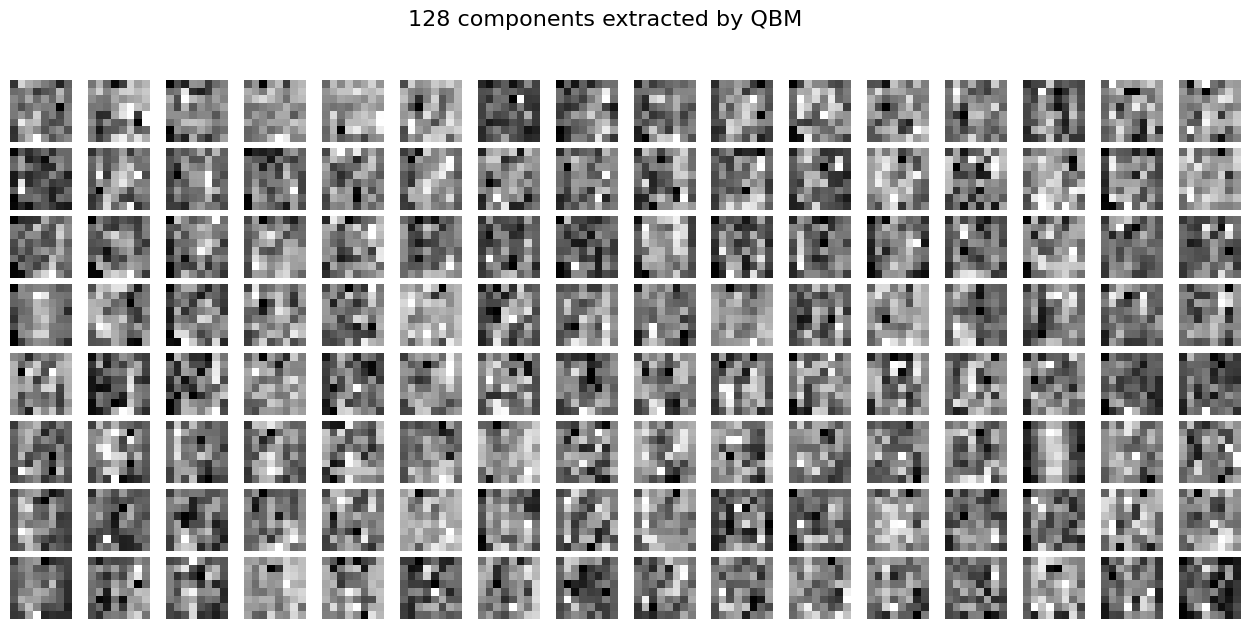

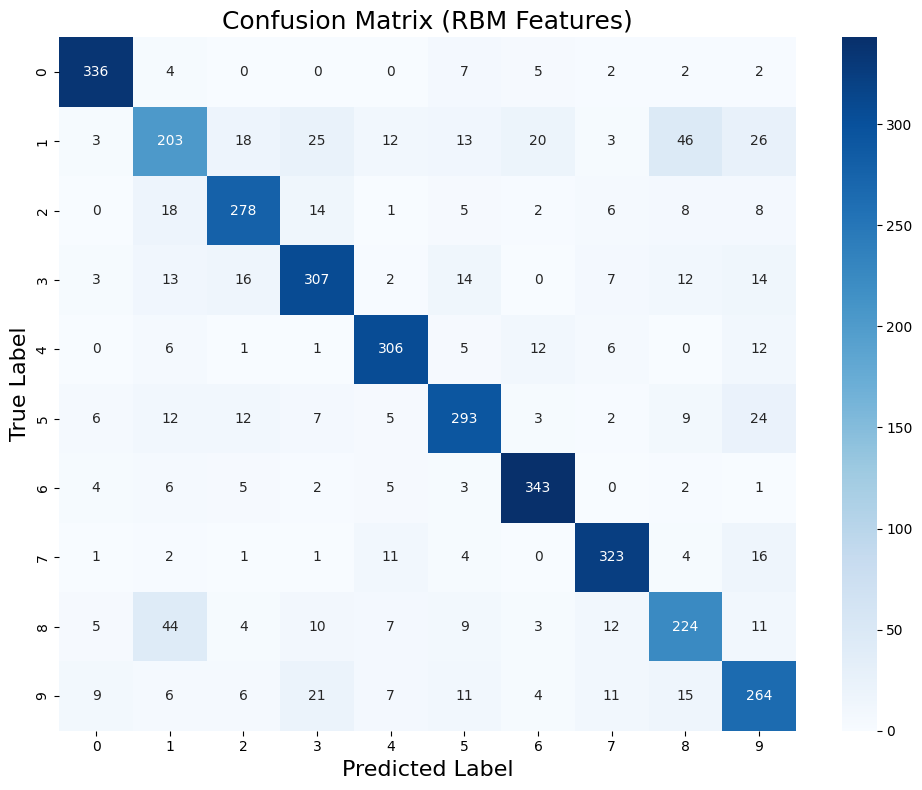

In [13]:
# 绘制权重
rbm.plot_weights(rbm, save_pdf=False)

# 绘制混淆矩阵
rbm.plot_confusion_matrix(y_test, log_pred, title_suffix="RBM Features", save_pdf=False)